In [ ]:
# FOR GOOGLE COLAB 
## comment this block when program is on local machine 
#from google.colab import drive
#drive.mount('/gdrive')
#%cd /gdrive

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import math
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import itertools
import warnings
warnings.filterwarnings('ignore')

In [ ]:
path= "/content/drive/MyDrive/time series/train.csv"

In [ ]:
file_1 = pd.read_csv(path)

In [ ]:
file_1

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


# EDA

Memory Reduction

In [ ]:
def Memory_Reduction_Optimization(DataFrame):
    cols = DataFrame.dtypes.index.tolist()
    types = DataFrame.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if DataFrame[cols[i]].min() > np.iinfo(np.int8).min and DataFrame[cols[i]].max() < np.iinfo(np.int8).max:
                DataFrame[cols[i]] = DataFrame[cols[i]].astype(np.int8)
            elif DataFrame[cols[i]].min() > np.iinfo(np.int16).min and DataFrame[cols[i]].max() < np.iinfo(np.int16).max:
                DataFrame[cols[i]] = DataFrame[cols[i]].astype(np.int16)
            elif DataFrame[cols[i]].min() > np.iinfo(np.int32).min and DataFrame[cols[i]].max() < np.iinfo(np.int32).max:
                DataFrame[cols[i]] = DataFrame[cols[i]].astype(np.int32)
            else:
                DataFrame[cols[i]] = DataFrame[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if DataFrame[cols[i]].min() > np.finfo(np.float16).min and DataFrame[cols[i]].max() < np.finfo(np.float16).max:
                DataFrame[cols[i]] = DataFrame[cols[i]].astype(np.float16)
            elif DataFrame[cols[i]].min() > np.finfo(np.float32).min and DataFrame[cols[i]].max() < np.finfo(np.float32).max:
                DataFrame[cols[i]] = DataFrame[cols[i]].astype(np.float32)
            else:
                DataFrame[cols[i]] = DataFrame[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                DataFrame[cols[i]] = pd.to_datetime(DataFrame[cols[i]], format='%Y-%m-%d')
            else:
                DataFrame[cols[i]] = DataFrame[cols[i]].astype('category')
    return DataFrame  

data = Memory_Reduction_Optimization(file_1)

In [ ]:
file_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   date    913000 non-null  category
 1   store   913000 non-null  int8    
 2   item    913000 non-null  int8    
 3   sales   913000 non-null  int16   
dtypes: category(1), int16(1), int8(2)
memory usage: 5.3 MB


In [ ]:
file_1['date'] =  pd.to_datetime(file_1['date'], format='%Y-%m-%d') 

In [ ]:
file_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int8          
 2   item    913000 non-null  int8          
 3   sales   913000 non-null  int16         
dtypes: datetime64[ns](1), int16(1), int8(2)
memory usage: 10.4 MB


In [ ]:
file_1.notna

<bound method DataFrame.notna of              date  store  item  sales
0      2013-01-01      1     1     13
1      2013-01-02      1     1     11
2      2013-01-03      1     1     14
3      2013-01-04      1     1     13
4      2013-01-05      1     1     10
...           ...    ...   ...    ...
912995 2017-12-27     10    50     63
912996 2017-12-28     10    50     59
912997 2017-12-29     10    50     74
912998 2017-12-30     10    50     62
912999 2017-12-31     10    50     82

[913000 rows x 4 columns]>

In [ ]:
file_1.index = pd.DatetimeIndex(file_1['date'])
file_1.drop('date', axis=1, inplace=True)

In [ ]:
#file_2 = int(len(file_1) * 0.50)

In [ ]:
#file_2

Splitting dataset

In [ ]:
x= file_1[['store','item']]
y=file_1[['sales']]

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.50, random_state = 2) # decrease the test Percentage (20,30,40%)
print("X-Train Shape: ", x_train.shape,'\n' "Y-Train Shape:", y_train.shape)
print("X-Test Shape: ", x_test.shape,'\n' "Y-Test Shape:", y_test.shape)

X-Train Shape:  (456500, 2) 
Y-Train Shape: (456500, 1)
X-Test Shape:  (456500, 2) 
Y-Test Shape: (456500, 1)


Normalization of data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling: subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. the validation and test sets ensure that you get (somewhat) honest metrics. 

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
#Min Max scaler

scaler.fit(x_train)
scaler.fit(x_test)
scaler.fit(y_test)
scaler.fit(y_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = scaler.transform(y_train)
y_test= scaler.transform(y_test)

#LSTM

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator
n_input = 2 # Total Input
n_features= 2 # Features 
generator = TimeseriesGenerator(x_train,x_train, length=n_input, batch_size=1)

Keras Sequential Model with Adam Optimizer 

In [ ]:

lstm_model = Sequential()
lstm_model.add(LSTM(32, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
lstm_model.compile(optimizer= opt, loss='mse')
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 32)                4480      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 4,513
Trainable params: 4,513
Non-trainable params: 0
_________________________________________________________________


Model Fitment

In [ ]:
lstm_model.fit_generator(generator,epochs=1)

456498/456498 [==============================] - 1183s 3ms/step - loss: 0.0182


Plotting Loss vs Epoch 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#losses_lstm = lstm_model.history.history
#plt.figure(figsize=(12,4))
#plt.xlabel("Epochs")
#plt.ylabel("Loss")
#plt.xticks(np.arange(0,21,1))
#plt.plot(range(len(losses_lstm)),losses_lstm);

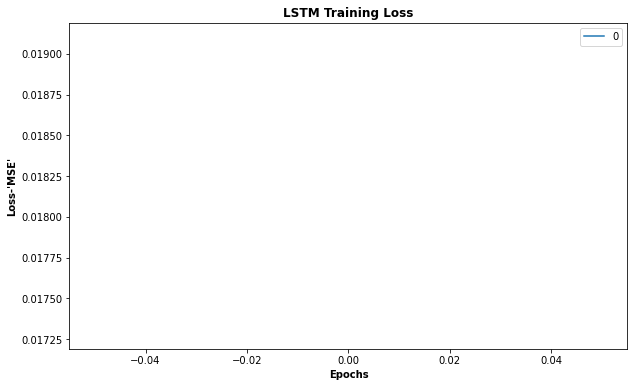

In [ ]:
loss = pd.DataFrame(lstm_model.history.history['loss'])


loss.plot(figsize=(10,6))
plt.title('LSTM Training Loss',fontweight='bold')
plt.xlabel('Epochs',fontweight='bold')
plt.ylabel("Loss-'MSE'",fontweight='bold');

LSTM Prediction

In [ ]:
lstm_predictions_scaled = list()

batch = x_train[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))



In [ ]:
for i in range(len(x_test)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [ ]:

lstm_predictions_scaled

In [ ]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [ ]:
lstm_predictions

Plotting Actual vs Prediction

In [ ]:
x_test['sales'].plot(figsize = (16,5), legend=True)
lstm_predictions.plot(legend = True);

In [ ]:
plt.plot(x_test['sales'], color = 'red', label = 'Actual sales')
plt.plot(lstm_predictions, color = 'blue', label = 'Predicted sales using LSTM')
plt.title('Actual Vs Prediction ')
plt.xlabel('Date')
plt.ylabel('sales')
plt.legend()
plt.show()

Error Calculation

In [ ]:
lstm_rmse_error = rmse(x_test['sales'], lstm_predictions)
lstm_mse_error = lstm_rmse_error**2
mean_value = train['sales'].mean()

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value}')